# Celia - water balance
Code to reproduce the water balance check in `varSubstep.f90`. `varSubstep.f90` code (line `657`):

```fortran
soilBalance0   = sum( (mLayerVolFracLiq(nSnow+1:nLayers)  + mLayerVolFracIce(nSnow+1:nLayers)  )*mLayerDepth(nSnow+1:nLayers) )
```
and line `791` and further:

```fortran
if(count(ixSoilOnlyHyd/=integerMissing)==nSoil)then
   soilBalance1 = sum( (mLayerVolFracLiqTrial(nSnow+1:nLayers) + mLayerVolFracIceTrial(nSnow+1:nLayers) )*mLayerDepth(nSnow+1:nLayers) )
   vertFlux     = -(iLayerLiqFluxSoil(nSoil) - iLayerLiqFluxSoil(0))*dt  ! m s-1 --> m
   tranSink     = sum(mLayerTranspire)*dt                                ! m s-1 --> m
   baseSink     = sum(mLayerBaseflow)*dt                                 ! m s-1 --> m
   compSink     = sum(mLayerCompress(1:nSoil) * mLayerDepth(nSnow+1:nLayers) ) ! dimensionless --> m
   liqError     = soilBalance1 - (soilBalance0 + vertFlux + tranSink - baseSink - compSink)
   if(abs(liqError) > absConvTol_liquid*10._dp)then   ! *10 because of precision issues
    !write(*,'(a,1x,f20.10)') 'dt = ', dt
    !write(*,'(a,1x,f20.10)') 'soilBalance0      = ', soilBalance0
    !write(*,'(a,1x,f20.10)') 'soilBalance1      = ', soilBalance1
    !write(*,'(a,1x,f20.10)') 'vertFlux          = ', vertFlux
    !write(*,'(a,1x,f20.10)') 'tranSink          = ', tranSink
    !write(*,'(a,1x,f20.10)') 'baseSink          = ', baseSink
    !write(*,'(a,1x,f20.10)') 'compSink          = ', compSink
    !write(*,'(a,1x,f20.10)') 'liqError          = ', liqError
    !write(*,'(a,1x,f20.10)') 'absConvTol_liquid = ', absConvTol_liquid
    waterBalanceError = .true.
    return
```

In [2]:
# modules
from pathlib import Path
from matplotlib.ticker import MultipleLocator
import numpy as np
import xarray as xr # note, also needs netcdf4 library installed
import matplotlib.pyplot as plt

In [3]:
# Specify the data locations relative to the notebook
sim_path = Path("./output")
sim_file = "celia1990_output_timestep.nc"

In [5]:
# selection parameters
GRU, HRU = 0,0

In [9]:
# function to calculate the water balance components on a given time step
def calc_wb_varSubstep(dat):
    
    # Input: xarray dataset with variables:
    # - time 
    # - nSoil
    # - nSnow
    # - nLayers
    # - mLayerDepth
    # - mLayerVolFracLiq
    # - mLayerVolFraqIce
    # - iLayerLiqFluxSoil
    # - mLayerTranspire
    # - mLayerBaseflow
    # - mLayerCompress
    
    # Make some storage variables
    vec_soilBalance0 = []
    vec_soilBalance1 = []
    vec_vertFlux = []
    vec_tranSink = []
    vec_baseSink = []
    vec_compSink = []
    vec_liqError = []
    
    # Find the timestep size [s]
    dt = round((dat['time'][1] - dat['time'][0]).values/np.timedelta64(1, 's'))
        
    # --- Water balance components ---
    # Start of time loop
    for t in range(0,len(dat['time'])-1):
    
        # Specify time as indices
        S_time = t 
        E_time = t+1
    
        # Get the layer variables at t=t
        S_nSoil   = dat['nSoil'].isel(time=S_time).values
        S_nSnow   = dat['nSnow'].isel(time=S_time).values
        S_nLayers = dat['nLayers'].isel(time=S_time).values
        S_mLayerDepth = dat['mLayerDepth'].isel(time=S_time,midToto=slice(S_nSnow,S_nLayers)).values # needs to start at index 0, not 1 in Python
        
        # Soil water at the start of t=t
        S_mLayerVolFraqLiq = dat['mLayerVolFracLiq'].isel(time=S_time,midToto=slice(S_nSnow,S_nLayers)).values
        S_mLayerVolFraqIce = dat['mLayerVolFracIce'].isel(time=S_time,midToto=slice(S_nSnow,S_nLayers)).values
        soilBalance0 = sum( (S_mLayerVolFraqLiq + S_mLayerVolFraqIce) * S_mLayerDepth )   
    
        # Layer variables at t=t+1
        E_nSoil   = dat['nSoil'].isel(time=E_time).values
        E_nSnow   = dat['nSnow'].isel(time=E_time).values
        E_nLayers = dat['nLayers'].isel(time=E_time).values
        E_mLayerDepth = dat['mLayerDepth'].isel(time=E_time,midToto=slice(E_nSnow,E_nLayers)).values # needs to start at index 0, not 1 in Python
        
        # Vertical downward flux between t=t and t=t+1 (needs t=t+1)
        iLayerLiqFluxSoil_top = dat['iLayerLiqFluxSoil'].isel(time=E_time,ifcSoil=E_nSoil).values
        iLayerLiqFluxSoil_bot = dat['iLayerLiqFluxSoil'].isel(time=E_time,ifcSoil=0).values
        vertFlux = -1* (iLayerLiqFluxSoil_top - iLayerLiqFluxSoil_bot) * dt
    
        # Transpiration between t=t and t=t+1 (needs t=t+1)
        tranSink = dat['mLayerTranspire'].isel(time=E_time).sum().values*dt 
    
        # Baseflow between t=t and t=t+1 (needs t=t+1)
        baseSink = dat['mLayerBaseflow'].isel(time=E_time).sum().values*dt
    
        # Compression between t=t and t=t+1 (needs t=t+1)
        mLayerCompress = dat['mLayerCompress'].isel(time=E_time,midSoil=slice(0,E_nSoil)).values
        compSink = sum(mLayerCompress * E_mLayerDepth)
    
        # Soil water at the end of t=t; i.e. at the start of t=t+1
        E_mLayerVolFraqLiq = dat['mLayerVolFracLiq'].isel(time=E_time,midToto=slice(E_nSnow,E_nLayers)).values
        E_mLayerVolFraqIce = dat['mLayerVolFracIce'].isel(time=E_time,midToto=slice(E_nSnow,E_nLayers)).values
        soilBalance1 = sum( (E_mLayerVolFraqLiq + E_mLayerVolFraqIce) * E_mLayerDepth )
    
        # Water balance error
        liqError = soilBalance1 - (soilBalance0 + vertFlux + tranSink - baseSink - compSink)
        
        # Append
        vec_soilBalance0.append(soilBalance0)
        vec_soilBalance1.append(soilBalance1)
        vec_vertFlux.append(vertFlux)
        vec_tranSink.append(tranSink)
        vec_baseSink.append(baseSink)
        vec_compSink.append(compSink)
        vec_liqError.append(liqError)
      
    return vec_soilBalance0, vec_soilBalance1, vec_vertFlux, vec_tranSink, vec_baseSink, vec_compSink, vec_liqError

Processing starts here

In [7]:
# Load the data
ds_celia = xr.open_dataset( sim_path / sim_file ).isel(hru=HRU, gru=GRU).load()

In [10]:
# Calculate the checks
wb_celia = calc_wb_varSubstep(ds_celia)

Figures

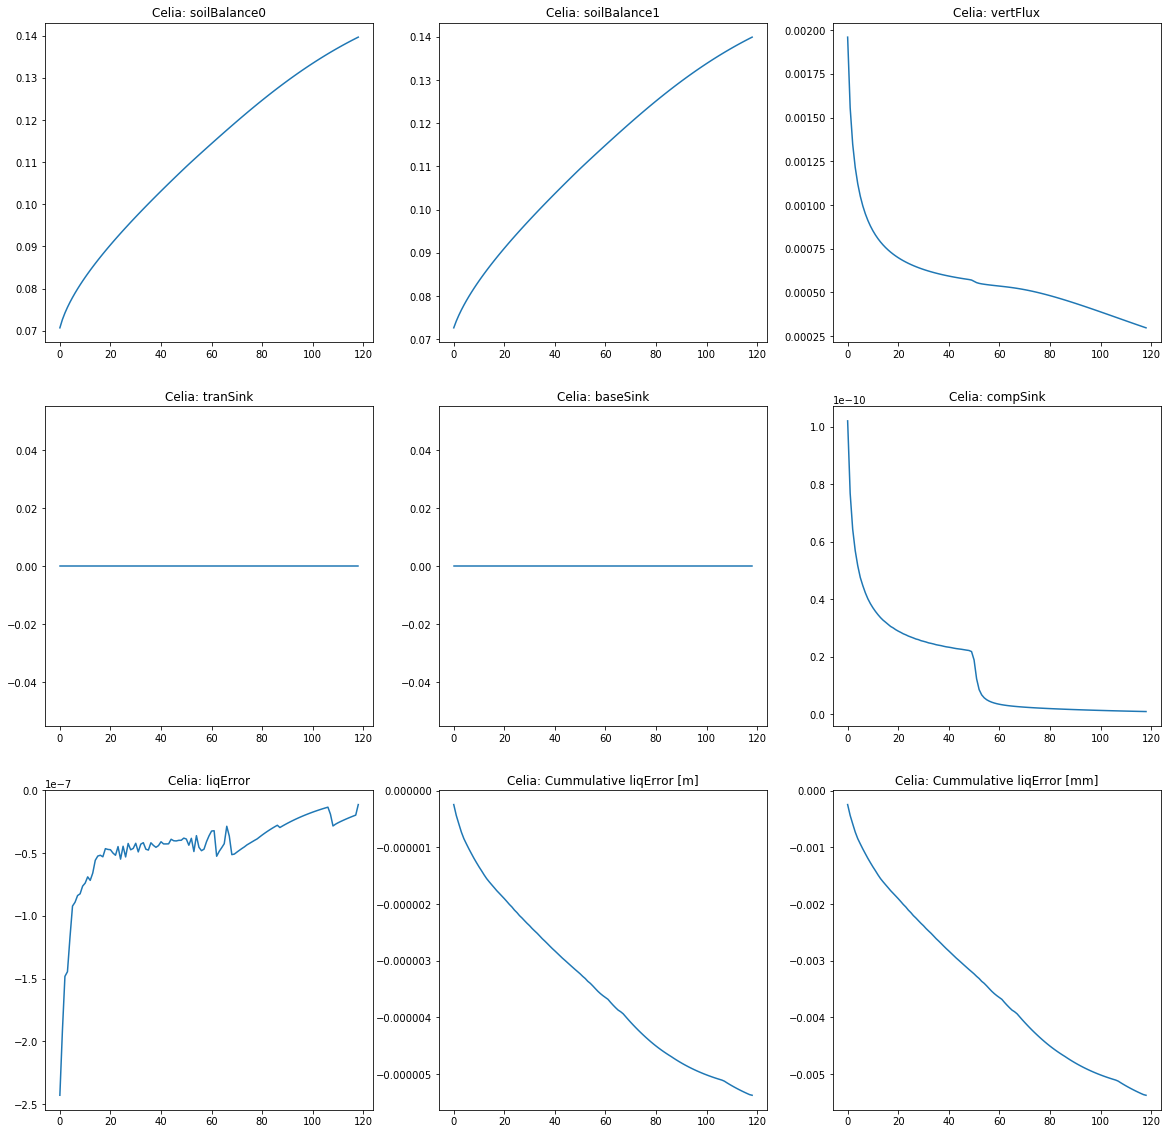

In [12]:
fig = plt.figure(figsize=(20,20))
nrow,ncol = 3,3
ttl_pre = 'Celia: '
save_pre = './img/celia_'
wb_out = wb_celia
ttl = ['soilBalance0','soilBalance1','vertFlux','tranSink','baseSink','compSink','liqError']

# plot Individual terms
for idx, var in enumerate(ttl):
    ax = fig.add_subplot(nrow,ncol,idx+1)
    ax.plot(wb_out[idx])
    ax.set_title(ttl_pre + var)
    
# Add a cumulative water balance error
liqError = np.asarray(wb_out[6])

ax = fig.add_subplot(nrow,ncol,idx+2)
ax.plot(np.cumsum(liqError))
ax.set_title(ttl_pre + 'Cummulative liqError [m]');

ax = fig.add_subplot(nrow,ncol,idx+3)
ax.plot(np.cumsum(liqError)*1000)
ax.set_title(ttl_pre + 'Cummulative liqError [mm]');

# save
plt.savefig(save_pre + 'varSubstep_water_balance.png')